In [1]:
import torch 
from torch import nn
from torch.autograd import Variable
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torchvision.datasets as dsets
import torchvision.transforms as T
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
sns.set(color_codes=True)
np.set_printoptions(precision=4, suppress=True)

In [2]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap="Blues")
    return 

In [3]:
batch_size = 100
hidden_dim = 128
latent_dim = 20

In [4]:
transform = T.Compose(
            [T.ToTensor()] 
            )
mnist_train = dsets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=5)

In [ ]:
show_images(mnist_train_loader.__iter__().next()[0].numpy())

In [9]:
class Vae(nn.Module):
    def __init__(self, hidden_dim, latent_dim):
        super(Vae, self).__init__()
        self.encode = nn.Sequential(
                       nn.Linear(784, hidden_dim),
                       nn.LeakyReLU(0.1, inplace=True),
                       nn.Linear(hidden_dim, hidden_dim),
                       nn.LeakyReLU(0.1, inplace=True)
                       )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)
        self.decode = nn.Sequential(
                      nn.Linear(latent_dim, hidden_dim),
                      nn.LeakyReLU(0.1, inplace=True),
                      nn.Linear(hidden_dim, hidden_dim),
                      nn.LeakyReLU(0.1, inplace=True),
                      nn.Linear(hidden_dim, 784),
                      nn.Sigmoid()
                      )
    def encoder(self, x):
        encode = self.encode(x)
        mu, logvar = self.mu(encode), self.logvar(encode)
        return mu, logvar
    
    def decoder(self, z):
        return self.decode(z)
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        eps = Variable(torch.randn(mu.data.size()).cuda())
        z = mu + eps * torch.exp(logvar/2.)
        reconst = self.decoder(z)
        return reconst, mu, logvar
        

In [8]:
vae = Vae(hidden_dim, latent_dim)
vae.cuda()
criterion = nn.BCELoss(size_average=False)
optim = torch.optim.Adam(vae.parameters(), 1e-3)

0 0 54447.3554688


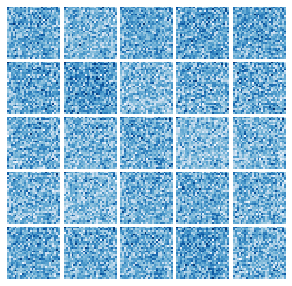

0 200 19577.5253906


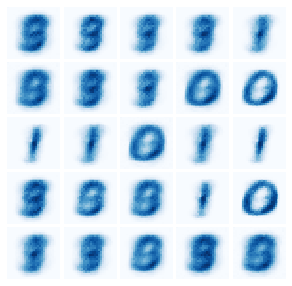

0 400 17287.4140625


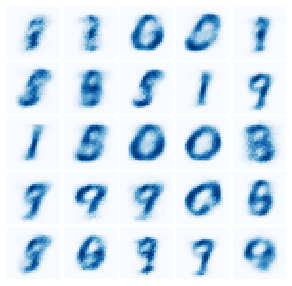

1 0 15541.9970703


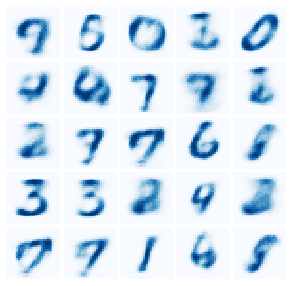

1 200 14207.1386719


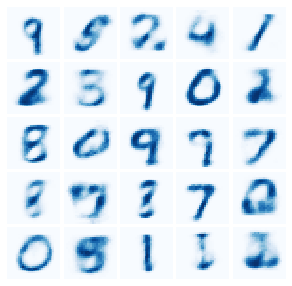

1 400 13335.0322266


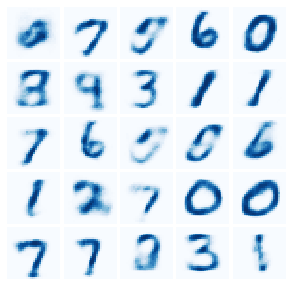

2 0 13114.5400391


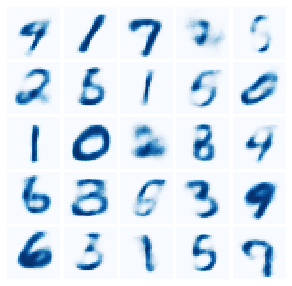

2 200 12671.0253906


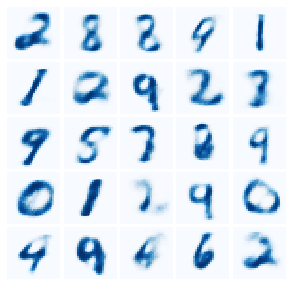

2 400 12787.8613281


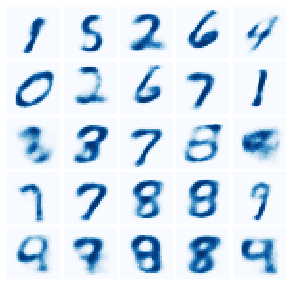

3 0 12165.8720703


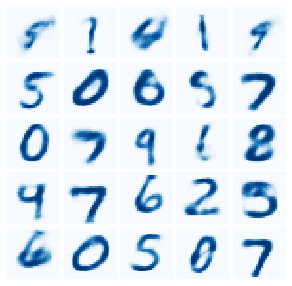

3 200 11599.65625


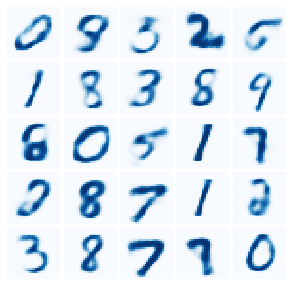

3 400 12058.9228516


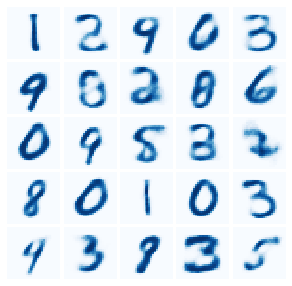

4 0 11545.8027344


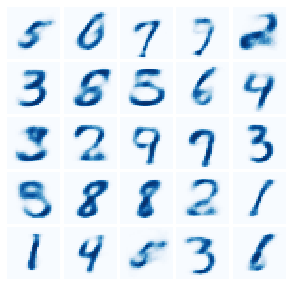

4 200 11758.2148438


In [ ]:
for e in range(10):
    for step, (images, _) in enumerate(mnist_train_loader):
        optim.zero_grad()
        x = Variable(images.view(batch_size, -1).cuda())
        x_recon, mu, logvar = vae(x)
        recon_loss = criterion(x_recon, x)
        kl_loss = torch.sum(0.5 * (mu**2 + torch.exp(logvar) - logvar -1))
        loss = recon_loss + kl_loss
        loss.backward()
        optim.step()
        
        if step % 200 == 0:
            print e, step, loss.data.cpu()[0]
            imgs = x_recon.data.cpu().numpy().reshape(batch_size, 28, 28)
            show_images(imgs[0:25])
            plt.show()

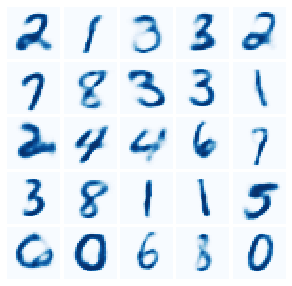

In [12]:
imgs = x_recon.data.cpu().numpy().reshape(batch_size, 28, 28)
show_images(imgs[0:25])
plt.show()